In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten,
                                     Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import pandas as pd

In [2]:
path="/content/drive/MyDrive/dataset/fer2013.csv"
data = pd.read_csv(path)
print(data.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [3]:
#pixels is a string of 2304 grayscale values (48x48 image), separated by spaces. convert the string to a NumPy array for each row
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, sep=' '))

In [4]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [5]:
#stack the pixel arrays into a 4D tensor: (samples, 48, 48, 1) suitable for CNNs and Normalized pixel values
X = np.stack(data['pixels'].values)
X = X.reshape(-1, 48, 48, 1)
X=X/255
# Labels
y = data['emotion'].values

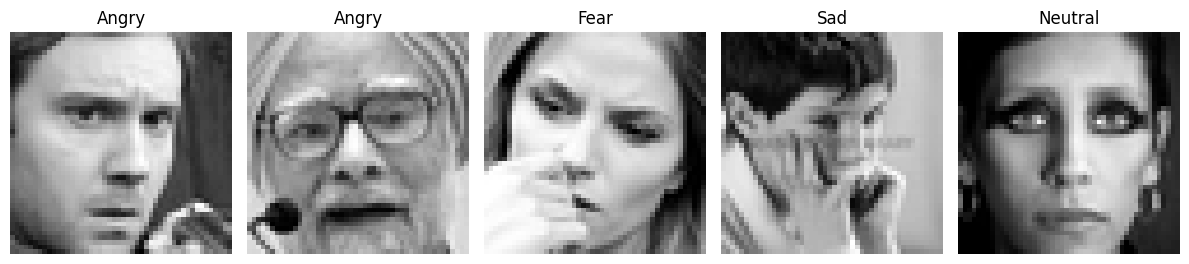

In [6]:
# Plot the first 5 images with their labels
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i].reshape(48, 48), cmap='gray')
    label_index = y[i] if isinstance(y[i], (int, np.integer)) else np.argmax(y[i])
    plt.title(emotion_labels[label_index] if label_index < len(emotion_labels) else f"Class {label_index}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
#Split into Training and Testing Sets
X_train = X[data['Usage'] == 'Training']
X_test = X[data['Usage'] == 'PrivateTest']
y_train = y[data['Usage'] == 'Training']
y_test = y[data['Usage'] == 'PrivateTest']

In [8]:
print("X_train shape:", X_train.shape)

X_train shape: (28709, 48, 48, 1)


In [9]:
#One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [10]:
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)
print("First 5 y_train entries:\n", y_train[:5])

y_train shape: (28709, 7)
y_train dtype: float64
First 5 y_train entries:
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [11]:
#image augmentation generator to apply random transformations.
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

In [13]:
#Building CNN Model
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

In [14]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [20]:
def model_fer(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [21]:
# Compile and train model
model = model_fer((48, 48, 1))
checkpoint = ModelCheckpoint("model_weights1.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2826 - loss: 2.1895
Epoch 1: val_accuracy improved from -inf to 0.42352, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 527s 581ms/step - accuracy: 0.2827 - loss: 2.1892 - val_accuracy: 0.4235 - val_loss: 1.5284
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4715 - loss: 1.3958
Epoch 2: val_accuracy improved from 0.42352 to 0.46392, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 552s 571ms/step - accuracy: 0.4715 - loss: 1.3958 - val_accuracy: 0.4639 - val_loss: 1.3398
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.5339 - loss: 1.2234
Epoch 3: val_accuracy did not improve from 0.46392
898/898 ━━━━━━━━━━━━━━━━━━━━ 555s 563ms/step - accuracy: 0.5339 - loss: 1.2234 - val_accuracy: 0.4452 - val_loss: 1.5566
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5556 - loss: 1.1718
Epoch 4: val_accuracy improved from 0.46392 to 0.51797, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 572s 574ms/step - accuracy: 0.5556 - loss: 1.1718 - val_accuracy: 0.5180 - val_loss: 1.2457
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5928 - loss: 1.0847
Epoch 5: val_accuracy improved from 0.51797 to 0.52828, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 548s 611ms/step - accuracy: 0.5928 - loss: 1.0847 - val_accuracy: 0.5283 - val_loss: 1.2511
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6098 - loss: 1.0369
Epoch 6: val_accuracy did not improve from 0.52828
898/898 ━━━━━━━━━━━━━━━━━━━━ 516s 560ms/step - accuracy: 0.6098 - loss: 1.0369 - val_accuracy: 0.5274 - val_loss: 1.2481
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6254 - loss: 1.0055
Epoch 7: val_accuracy improved from 0.52828 to 0.57203, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 573s 572ms/step - accuracy: 0.6254 - loss: 1.0055 - val_accuracy: 0.5720 - val_loss: 1.1368
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6814 - loss: 0.8615
Epoch 8: val_accuracy did not improve from 0.57203
898/898 ━━━━━━━━━━━━━━━━━━━━ 560s 570ms/step - accuracy: 0.6814 - loss: 0.8615 - val_accuracy: 0.5196 - val_loss: 1.3327
Epoch 9/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6985 - loss: 0.8230
Epoch 9: val_accuracy improved from 0.57203 to 0.57481, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 563s 571ms/step - accuracy: 0.6985 - loss: 0.8230 - val_accuracy: 0.5748 - val_loss: 1.1772
Epoch 10/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7351 - loss: 0.7315
Epoch 10: val_accuracy improved from 0.57481 to 0.59069, saving model to model_weights1.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 561s 570ms/step - accuracy: 0.7351 - loss: 0.7315 - val_accuracy: 0.5907 - val_loss: 1.1362


In [23]:
# Evaluate
model.evaluate(X_test, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5954 - loss: 1.1242


[1.1361678838729858, 0.5906937718391418]

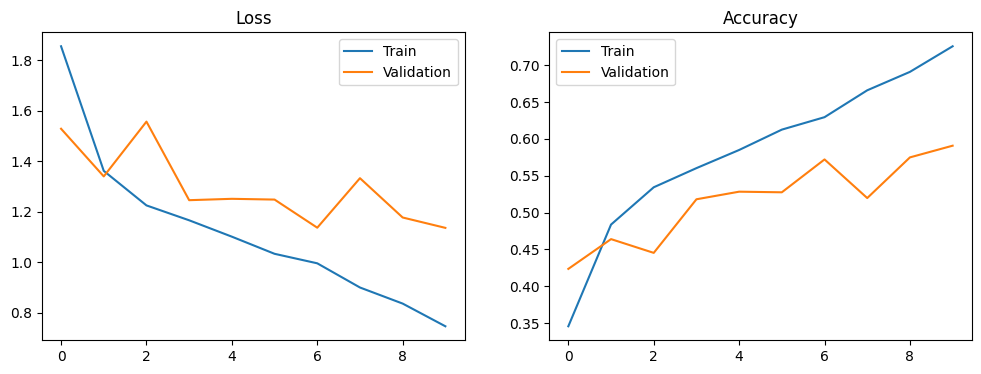

In [24]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.show()

In [25]:
# Save model architecture
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)

In [27]:
from google.colab import files

# Download both files
files.download("model_weights1.h5")
files.download("model_a.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>